# **Facial Recognition System**
## **1. Overview**
This FR system consists of three different models combined into an ensemble. The three models will be trained to specialise on a particular type of image data noise, namely - illumiation, pose and occlusion.

- **Part 1:** Illumination Specialised Model
- **Part 2:** Pose Specialised Model
- **Part 3:** Occlusion Specialised Model 


## **2. Illumination Specialised Model**
Credit to George Arnall for inspiring some of the code in this section of the repo with his project [Yale Face Recognition](https://www.kaggle.com/code/georgearnall/yale-face-recognition)

### **2.1 Imports**

In [33]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd 
import cv2 
from PIL import Image 

import mtcnn 
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

import os
from os import listdir 
from tqdm import tqdm 
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns 

### **2.2 EDA**

In [34]:
DIRECTORY = "./dataset/illumination/"

(243, 320, 3)


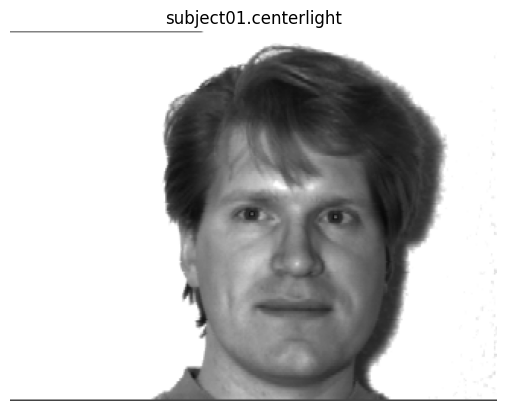

In [35]:
# Let's display one of the images to see what it looks like
filename = f"{DIRECTORY}subject01.centerlight"
# Read the images pixels using imread method of plt which reads an image from a file into an array.
pixels = plt.imread(filename)

rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)
plt.imshow(rgb_pixels)
plt.title(filename.split('/')[-1])
plt.axis('off')
plt.show()

['./dataset/illumination/subject04.leftlight', './dataset/illumination/subject01.wink', './dataset/illumination/subject06.surprised']


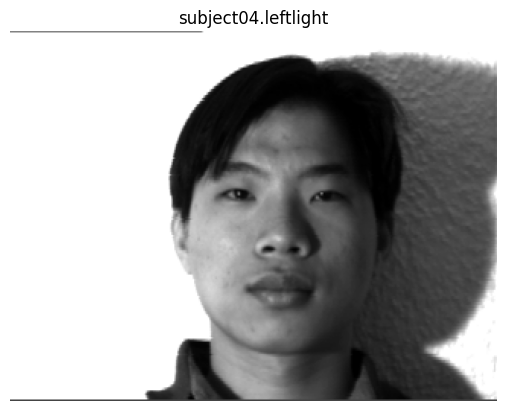

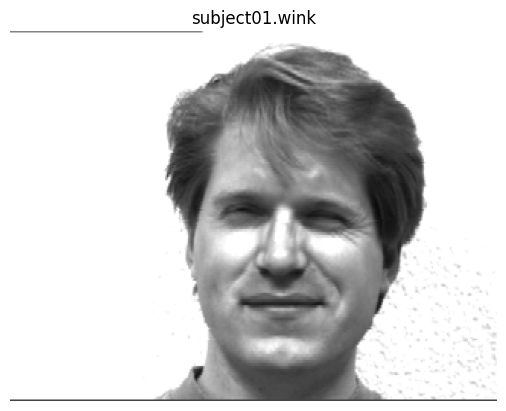

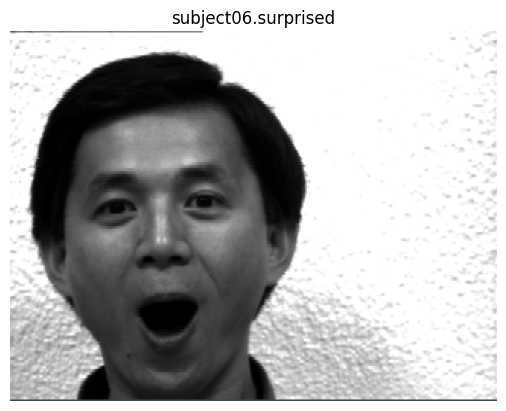

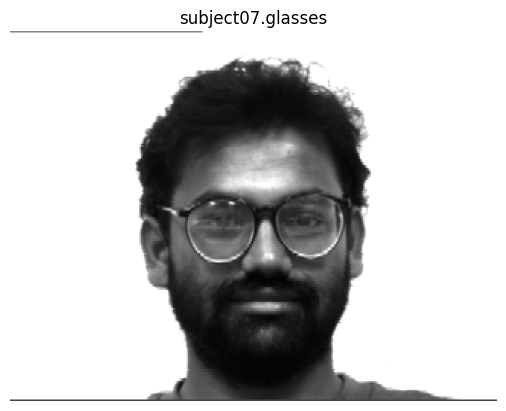

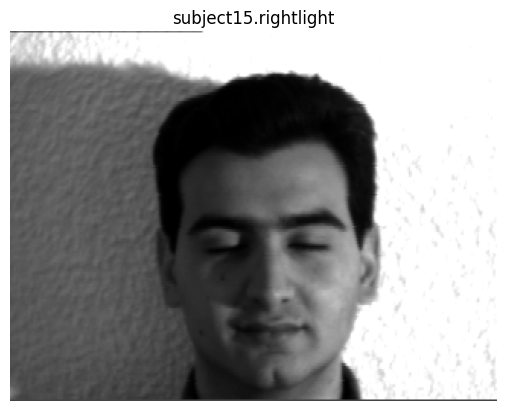

In [36]:
# Let's check out a few more faces
filenames = listdir(DIRECTORY)
full_filenames = [os.path.join(DIRECTORY, f) for f in filenames]
print(full_filenames[:3])

# Read the images pixels using imread method of plt which reads an image from a file into an array.
for f in filenames[:5]: 
    f_path = os.path.join(DIRECTORY, f)
    pixels = plt.imread(f_path)
    rgb = np.stack((pixels, pixels, pixels), axis=2)
    plt.imshow(rgb)
    plt.title(f)
    plt.axis('off')
    plt.show()


In each of the images, the face is positioned in a different region. The first task is to normalise all of the face positions so that they can reliably be fed into a classifier. There are are few techniques to achieve this. Haar Cascades provide a simple and fast method for detecting faces but they can be unreliable. They are ideally suited to real time detection. Facial identification can afford to spend longer processing the image. Therefore we will use MTCNN which is a face detection algorithm using a CNN, it achieves much higher accuracy than other techniques.

In [37]:
# Create the detector, using default weights
detector = MTCNN()
# detect faces in the image 
results = detector.detect_faces(rgb_pixels)
results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[{'box': [121, 69, 122, 154],
  'confidence': 0.9999041557312012,
  'keypoints': {'left_eye': (160, 122),
   'right_eye': (214, 123),
   'nose': (189, 152),
   'mouth_left': (163, 182),
   'mouth_right': (210, 184)}}]

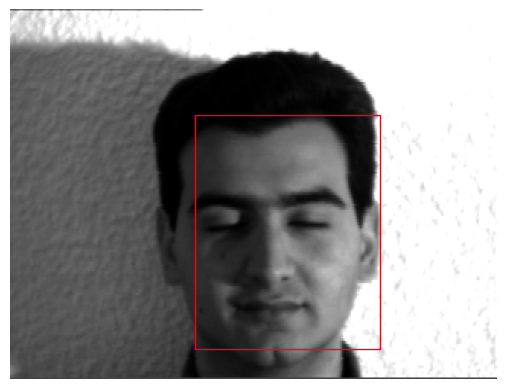

In [38]:
# draw an inage with detected objects 
def draw_image_with_boxes(data, result_list):
    # plot the image
    plt.imshow(data)
    # get the current axes for the pot which will allow us to make complex modifications to our plots like in this case where we want to draw boxes 
    ax = plt.gca()
    # plot each box 
    for result in result_list: 
        # get coordinates
        x, y, width, height = result['box']
        # create the shape (starting point is x, y, and the height and width give the extent to which the box stretches) 
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.axis('off')
    plt.show()

# display faces on the original image 
draw_image_with_boxes(rgb, results)

The next step is to extract and normalise the face pixels so that they can reliably be used for classifying.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


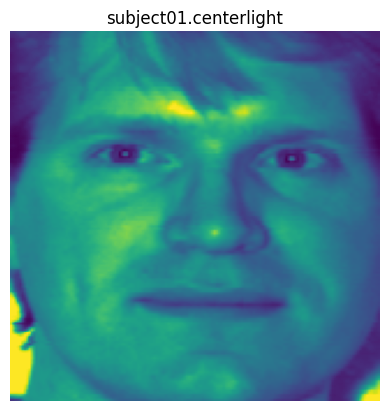

In [39]:
# extract a single face from a given photograph
def extract_face_from_file(filename, required_size=(160, 160)):
    # load image from file 
    image = Image.open(filename)

    return extract_face(image, required_size)

def extract_face(image, required_size=(160, 160)): 
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array 
    pixels = np.asarray(image)
    # detect faces in the image 
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face because a list is returned as the method detects face(s) plural
    x1, y1, width, height = results[0]['box']
    # bug fix 
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract these pixels where the face is 
    face = pixels[y1:y2, x1:x2]
    # reszie pixels to the model size 
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)

    return gray_face

detector = MTCNN()

filename = "subject01.centerlight"
face_pixels = extract_face_from_file(f"{DIRECTORY}/{filename}")

plt.title(filename)
plt.axis('off')
plt.imshow(face_pixels)

### **2.3 Building the dataset**
We need to extract the faces for all the images so that we can create our dataset for training/testing.

In [40]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)

  0%|          | 0/16 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  6%|▋         | 1/16 [00:00<00:05,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 12%|█▎        | 2/16 [00:00<00:05,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 19%|█▉        | 3/16 [00:01<00:04,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 25%|██▌       | 4/16 [00:01<00:04,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 31%|███▏      | 5/16 [00:01<00:03,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 38%|███▊      | 6/16 [00:02<00:03,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 44%|████▍     | 7/16 [00:02<00:02,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 50%|█████     | 8/16 [00:02<00:02,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 56%|█████▋    | 9/16 [00:02<00:02,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 62%|██████▎   | 10/16 [00:03<00:01,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 69%|██████▉   | 11/16 [00:03<00:01,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 75%|███████▌  | 12/16 [00:03<00:01,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 81%|████████▏ | 13/16 [00:04<00:00,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 88%|████████▊ | 14/16 [00:04<00:00,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 94%|█████████▍| 15/16 [00:04<00:00,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


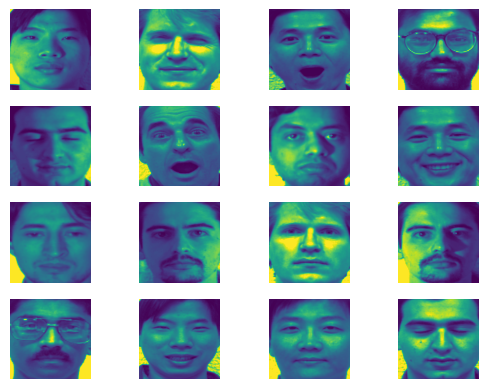

In [41]:
i = 1
faces = list()

# We're only concerned with files in the directory that have "subject" in them as these are the data items we'll use to train our model. 
for filename in tqdm(list_files(DIRECTORY, "subject")[0:16]):
    # full path
    path = DIRECTORY + filename 
    # get normalized face
    face = extract_face_from_file(path)
    # plot 
    plt.subplot(4, 4, i)
    plt.axis('off')
    plt.imshow(face)
    faces.append(face)
    i += 1

plt.show()

### **2.4 Setup the test-train data**

In [54]:
# list the filenames
filenames = pd.DataFrame(list_files(DIRECTORY, "subject"))

# generate split to create a df with each part of the split in it's own individual column
df = filenames[0].str.split('.', expand=True)
df['filename'] = filenames 
df = df.rename(columns = {0:'subject', 1:'category'}) # Rename the columns to a more appropriate name
df['subject'] = df.subject.str.replace('subject', '') # Change the values in the subject column to simply be the number referring to the candidate as opposed ot subject01 for example
df['subject'] = pd.to_numeric(df['subject'])
df

,subject,category,filename
0,4,leftlight,subject04.leftlight
1,1,wink,subject01.wink
2,6,surprised,subject06.surprised
3,7,glasses,subject07.glasses
4,15,rightlight,subject15.rightlight
...,...,...,...
160,1,sad,subject01.sad
161,15,sad,subject15.sad
162,11,noglasses,subject11.noglasses
163,13,happy,subject13.happy


In [66]:
unique_vals = df['subject'].unique()
print("Unique Values: ", unique_vals,  sep='')
print("Length: " + str(len(unique_vals)))

Unique Values: [ 4  1  6  7 15 12 10  3  9 13 14 11  2  5  8]
Length: 15
